# Sentiment Analysis using LSTM model

# Introduction (Method)

To conduct sentiment analysis using an LSTM model, the Amazon review dataset from Kaggle ([available from Kaggle](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews)) was used. The dataset has already been adapted into ratings (0: negative, 1: positive). After importing training, validation, and test data, new training datasets of sizes 10%, 25%, and 50% were created to evaluate the impact of data volume. These new training datasets, along with a full training dataset, were applied to the LSTM model.!

Additionally, encoders with 100-word, 250-word, and 500-word vocabularies were created to investigate whether the number of stored frequent words impacts LSTM models.

Firstly, the impact of dataset size on performance was investigated. LSTM models were trained using 10%, 25%, and 50% of the training data. For each model, the following training hyperparameters were used:

* Use 4 LSTM modules
* Use a 100-word encoder
* Train for 15 epochs

Secondly, the effect of the number of LSTM modules on model performance was examined. Models with 8 LSTM units and 12 LSTM units were created and trained. For each model, the following training parameters were utilised:

* Create and use a 250-word encoder
* Use 25% of the training data
* Train for 15 epochs

Thirdly, the investigation focused on how the size of the encoder's vocabulary impacts model performance. Models using encoders with 250-word and 500-word vocabularies were created. For each model, the following training parameters were used:

* Utilise a model with 4 LSTM modules
* Use 25% of the training data
* Train for 15 epochs
Finally, the best model was considered based on experiments regarding dataset size, the number of LSTM modules, and the size of the encoder's vocabulary. Hyperparameters were set based on previous experiments.


## Importing the required libraries

In [1]:
import numpy as np
import tensorflow as tf
import json

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
%matplotlib inline

## Creating some constants

In [2]:
EMBEDDING_LEN = 32  # The length of the word embedding vector
BATCH_SIZE = 1024

In [3]:
METRICS = [
      lambda : tf.keras.metrics.TruePositives(name='tp'),
      lambda : tf.keras.metrics.FalsePositives(name='fp'),
      lambda : tf.keras.metrics.TrueNegatives(name='tn'),
      lambda : tf.keras.metrics.FalseNegatives(name='fn'), 

      lambda : tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      lambda : tf.keras.metrics.Precision(name='precision'),
      lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## Loading the data: see note about dataset sizes above

In [4]:
train_filename = '/datasets/amazon-reviews/train.csv'
val_filename = '/datasets/amazon-reviews/validation.csv'
test_filename = '/datasets/amazon-reviews/test.csv'

In [5]:
train_data = tf.data.experimental.make_csv_dataset(train_filename, batch_size=BATCH_SIZE, num_epochs=1)
train_data = train_data.map(lambda d: (d['Review'], d['Rating']))

In [6]:
# take 10% of the training data
train_data10 = train_data.shard(10, 0)

train_data10 = train_data10.cache()
train_data10 = train_data10.shuffle(50000)
train_data10 = train_data10.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [7]:
# take 25% of the training data
train_data25 = train_data.shard(4, 0)

train_data25 = train_data25.cache()
train_data25 = train_data25.shuffle(50000)
train_data25 = train_data25.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [8]:
# take 50% of the training data
train_data50 = train_data.shard(2, 0)

train_data50 = train_data50.cache()
train_data50 = train_data50.shuffle(50000)
train_data50 = train_data50.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [9]:
# use all the training data
train_data = train_data.cache()
train_data = train_data.shuffle(50000)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [10]:
validation_data = tf.data.experimental.make_csv_dataset(val_filename, batch_size=BATCH_SIZE, num_epochs=1)
validation_data = validation_data.map(lambda d: (d['Review'], d['Rating']))
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [11]:
test_data = tf.data.experimental.make_csv_dataset(test_filename, batch_size=BATCH_SIZE, num_epochs=1)
test_data = test_data.map(lambda d: (d['Review'], d['Rating']))
test_data = test_data.cache()
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating encoders

The following code creates and saves text encoders for different vocabulary sizes. Running this code will take some time, but this saves the files for use later.

After your first run of this notebook, comment out the cells that adapt and save the encoders.

In [12]:
!mkdir encoder100
!mkdir encoder250
!mkdir encoder500

mkdir: cannot create directory ‘encoder100’: File exists
mkdir: cannot create directory ‘encoder250’: File exists
mkdir: cannot create directory ‘encoder500’: File exists


### Create, adapt, and save an encoder

You will only need to do this once. You may like to comment out the code in these cells after the first run.

In [13]:
encoder = tf.keras.layers.TextVectorization(max_tokens=100)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder100')

In [14]:
encoder = tf.keras.layers.TextVectorization(max_tokens=250)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder250')

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens=500)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder500')

### Create an encoder and load its assets from file

In [16]:
encoder100 = tf.keras.layers.TextVectorization(max_tokens=100)
encoder100.load_assets('encoder100')

In [17]:
encoder250 = tf.keras.layers.TextVectorization(max_tokens=250)
encoder250.load_assets('encoder250')

In [18]:
encoder500 = tf.keras.layers.TextVectorization(max_tokens=500)
encoder500.load_assets('encoder500')

# Trial before LSTM model analysis

The following is an example LSTM model, using a vocabulary size of 100 words, 4 LSTM units, trained over 5 epochs with 10% of the training dataset.

The model and training records are saved as `example_model`

In [30]:
# Build a model
example_model = Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4),
    Dense(1, activation='sigmoid')
])

In [31]:
# Compile the model
example_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')

example_history = example_model.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

example_model.save('example_review.keras')
with open('example_review_history.json', 'w') as f:
    json.dump(example_history.history, f)
    

Epoch 1/5
352/352 [==============================] - 45s 38ms/step - loss: 0.5363 - accuracy: 0.7449 - val_loss: 0.4413 - val_accuracy: 0.8042
Epoch 2/5
352/352 [==============================] - 12s 33ms/step - loss: 0.4143 - accuracy: 0.8150 - val_loss: 0.3979 - val_accuracy: 0.8216
Epoch 3/5
352/352 [==============================] - 12s 34ms/step - loss: 0.3888 - accuracy: 0.8250 - val_loss: 0.3807 - val_accuracy: 0.8294
Epoch 4/5
352/352 [==============================] - 12s 33ms/step - loss: 0.3755 - accuracy: 0.8318 - val_loss: 0.3705 - val_accuracy: 0.8354
Epoch 5/5
352/352 [==============================] - 12s 33ms/step - loss: 0.3654 - accuracy: 0.8370 - val_loss: 0.3649 - val_accuracy: 0.8390


Reload the model and training history

In [32]:
example_model = tf.keras.models.load_model('example_review.keras')
with open('example_review_history.json') as f:
    example_history = json.load(f)

Plot the training history

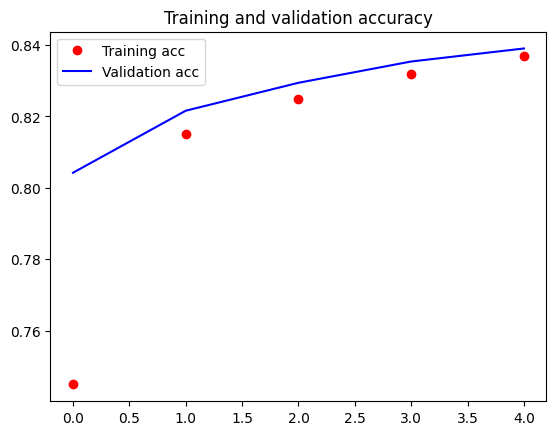

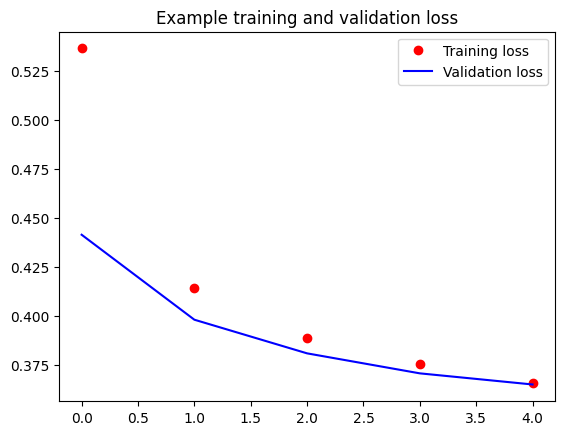

In [33]:
acc = example_history['accuracy']
val_acc = example_history['val_accuracy']
loss = example_history['loss']
val_loss = example_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

Evaluate the model

In [34]:
example_model.compile(metrics=fresh_metrics())
example_model_results = example_model.evaluate(validation_data, return_dict=True)
example_model_results

79/79 [==============================] - 3s 22ms/step - loss: 0.0000e+00 - tp: 34235.0000 - fp: 7181.0000 - tn: 32887.0000 - fn: 5697.0000 - accuracy: 0.8390 - precision: 0.8266 - recall: 0.8573


{'loss': 0.0,
 'tp': 34235.0,
 'fp': 7181.0,
 'tn': 32887.0,
 'fn': 5697.0,
 'accuracy': 0.8390250205993652,
 'precision': 0.8266128897666931,
 'recall': 0.8573324680328369}

# Investigating the size of the dataset

The first investigation is how the number of LSTM modules impacts the performance of the model.

For your models you should:
* use 4 LSTM modules
* use a 100-word encoder
* train for 15 epochs


##  Training 10% of the dataset

In [35]:
# put your code here
# Build the model
model_10 = Sequential([
    encoder100,
    Embedding(input_dim=len(encoder100.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4),
    Dense(1, activation='sigmoid')
])

In [36]:
# Compile the model
model_10.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=fresh_metrics())


In [37]:
# Train the model
history_10 = model_10.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

Epoch 1/15
352/352 [==============================] - 19s 40ms/step - loss: 0.6065 - tp: 114260.0000 - fp: 51616.0000 - tn: 129262.0000 - fn: 65310.0000 - accuracy: 0.6756 - precision: 0.6888 - recall: 0.6363 - val_loss: 0.5593 - val_tp: 28031.0000 - val_fp: 10960.0000 - val_tn: 29108.0000 - val_fn: 11901.0000 - val_accuracy: 0.7142 - val_precision: 0.7189 - val_recall: 0.7020
Epoch 2/15
352/352 [==============================] - 12s 35ms/step - loss: 0.5524 - tp: 126805.0000 - fp: 49248.0000 - tn: 131630.0000 - fn: 52765.0000 - accuracy: 0.7170 - precision: 0.7203 - recall: 0.7062 - val_loss: 0.5448 - val_tp: 28826.0000 - val_fp: 11241.0000 - val_tn: 28827.0000 - val_fn: 11106.0000 - val_accuracy: 0.7207 - val_precision: 0.7194 - val_recall: 0.7219
Epoch 3/15
352/352 [==============================] - 12s 34ms/step - loss: 0.5442 - tp: 125441.0000 - fp: 46733.0000 - tn: 134145.0000 - fn: 54129.0000 - accuracy: 0.7202 - precision: 0.7286 - recall: 0.6986 - val_loss: 0.5410 - val_tp: 29

In [38]:
# Save the model and training history
model_10.save('model_10.keras')
with open('history_10.json', 'w') as f:
    json.dump(history_10.history, f)

In [34]:
# Reload
model_10 = tf.keras.models.load_model('model_10.keras')
with open('history_10.json') as f:
    history_10 = json.load(f)

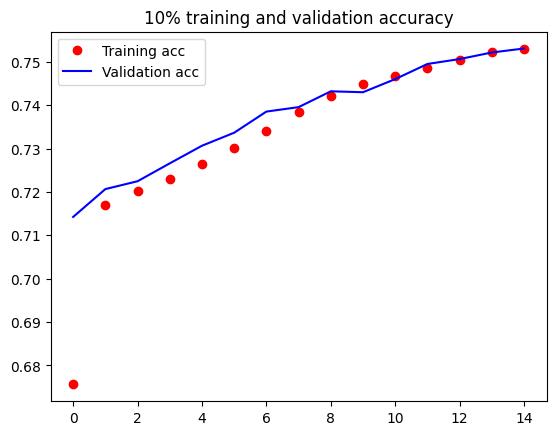

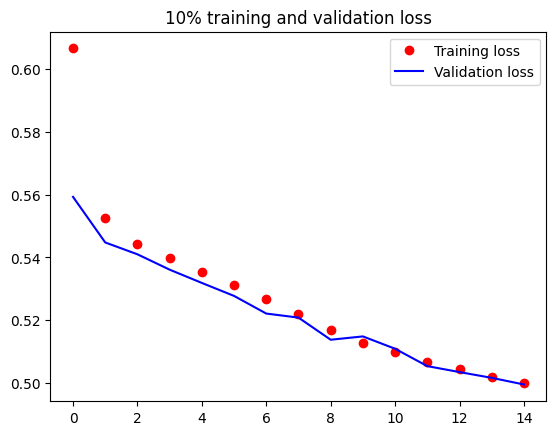

In [35]:
# Create the plot
acc_10 = history_10['accuracy']
val_acc_10 = history_10['val_accuracy']
loss_10 = history_10['loss']
val_loss_10 = history_10['val_loss']

epochs = range(len(acc_10))

plt.plot(epochs, acc_10, 'ro', label='Training acc')
plt.plot(epochs, val_acc_10, 'b', label='Validation acc')
plt.title('10% training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_10, 'ro', label='Training loss')
plt.plot(epochs, val_loss_10, 'b', label='Validation loss')
plt.title('10% training and validation loss')
plt.legend()

plt.show()

Comment:

Regarding accuracy, validation started around 0.71, and both training and validation followed a similar trend, gradually increasing, forming a straight line, and reaching 0.75. Concerning loss, validation started around 0.56. Subsequently, both training and validation displayed a similar trend, gradually decreasing, forming a straight line, and reaching around 0.50.

In [44]:
model_10.compile(metrics=fresh_metrics())
# Evaluate Model with 10% of the Training Data
model_10_results = model_10.evaluate(test_data, return_dict=True)
model_10_results

313/313 [==============================] - 8s 22ms/step - loss: 0.0000e+00 - tp: 121237.0000 - fp: 40105.0000 - tn: 119827.0000 - fn: 38831.0000 - accuracy: 0.7533 - precision: 0.7514 - recall: 0.7574


{'loss': 0.0,
 'tp': 121237.0,
 'fp': 40105.0,
 'tn': 119827.0,
 'fn': 38831.0,
 'accuracy': 0.7533249855041504,
 'precision': 0.7514286637306213,
 'recall': 0.7574093341827393}

## Training 25% of the dataset

In [45]:
# put your code here

# Build the model
model_25 = Sequential([
    encoder100,
    Embedding(input_dim=len(encoder100.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_25.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=fresh_metrics())

In [46]:
# Train the model
history_25 = model_25.fit(
    train_data25, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

# Save the model and training history
model_25.save('model_25.keras')
with open('history_25.json', 'w') as f:
    json.dump(history_25.history, f)


Epoch 1/15
879/879 [==============================] - 65s 34ms/step - loss: 0.5710 - tp: 306801.0000 - fp: 122000.0000 - tn: 327624.0000 - fn: 143671.0000 - accuracy: 0.7048 - precision: 0.7155 - recall: 0.6811 - val_loss: 0.5426 - val_tp: 28306.0000 - val_fp: 10594.0000 - val_tn: 29474.0000 - val_fn: 11626.0000 - val_accuracy: 0.7222 - val_precision: 0.7277 - val_recall: 0.7089
Epoch 2/15
879/879 [==============================] - 28s 32ms/step - loss: 0.5383 - tp: 316767.0000 - fp: 113890.0000 - tn: 335734.0000 - fn: 133705.0000 - accuracy: 0.7249 - precision: 0.7355 - recall: 0.7032 - val_loss: 0.5319 - val_tp: 27591.0000 - val_fp: 9333.0000 - val_tn: 30735.0000 - val_fn: 12341.0000 - val_accuracy: 0.7291 - val_precision: 0.7472 - val_recall: 0.6909
Epoch 3/15
879/879 [==============================] - 28s 32ms/step - loss: 0.5276 - tp: 318300.0000 - fp: 107938.0000 - tn: 341686.0000 - fn: 132172.0000 - accuracy: 0.7332 - precision: 0.7468 - recall: 0.7066 - val_loss: 0.5210 - val_t

In [47]:
# Reload
model_25 = tf.keras.models.load_model('model_25.keras')
with open('history_25.json') as f:
    history_25 = json.load(f)

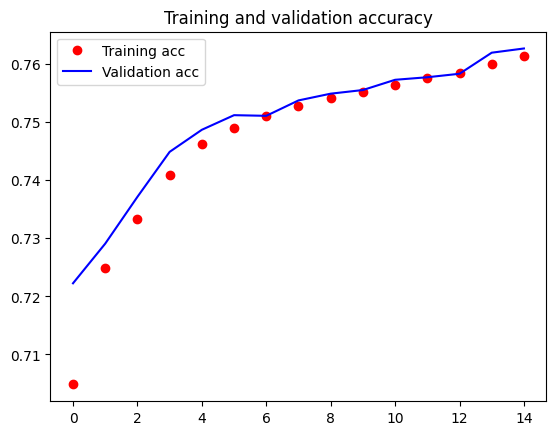

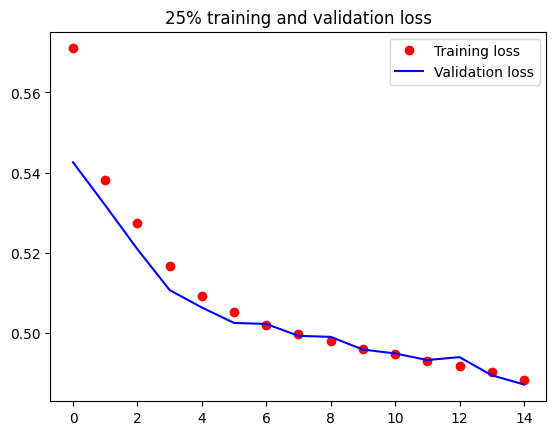

In [49]:
# Create the plot
acc_25 = history_25['accuracy']
val_acc_25 = history_25['val_accuracy']
loss_25 = history_25['loss']
val_loss_25 = history_25['val_loss']

epochs = range(len(acc_25))

plt.plot(epochs, acc_25, 'ro', label='Training acc')
plt.plot(epochs, val_acc_25, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_25, 'ro', label='Training loss')
plt.plot(epochs, val_loss_25, 'b', label='Validation loss')
plt.title('25% training and validation loss')
plt.legend()

plt.show()

Comment:

When it comes to accuracy, validation started around 0.72 with both training and validation showing parallel trends. Although there was a slight gap between training and validation up to 5 epochs, both increased, forming a curvy line, and reaching 0.76. 

Regarding loss, validation started around 0.54. Subsequently, both training and validation displayed a similar trend. Like accuracy, there was a slight gap between training and validation up to 5 epochs; however, both decreased, forming a curvy line, and reaching below 0.50.


In [50]:
model_25.compile(metrics=fresh_metrics())
# Evaluate Model with 25% of the Training Data
model_25_results = model_25.evaluate(test_data, return_dict=True)
model_25_results

313/313 [==============================] - 8s 22ms/step - loss: 0.0000e+00 - tp: 118612.0000 - fp: 34670.0000 - tn: 125262.0000 - fn: 41456.0000 - accuracy: 0.7621 - precision: 0.7738 - recall: 0.7410


{'loss': 0.0,
 'tp': 118612.0,
 'fp': 34670.0,
 'tn': 125262.0,
 'fn': 41456.0,
 'accuracy': 0.7621062397956848,
 'precision': 0.7738155722618103,
 'recall': 0.7410100698471069}

## Training 50% of the dataset

In [51]:
# put your code here
# Build the model
model_50 = Sequential([
    encoder100,
    Embedding(input_dim=len(encoder100.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_50.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=fresh_metrics())

# Train the model
history_50 = model_50.fit(
    train_data50, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

# Save the model and training history
model_50.save('model_50.keras')
with open('history_50.json', 'w') as f:
    json.dump(history_50.history, f)

Epoch 1/15
1758/1758 [==============================] - 90s 32ms/step - loss: 0.5619 - tp: 606876.0000 - fp: 225038.0000 - tn: 674839.0000 - fn: 293439.0000 - accuracy: 0.7120 - precision: 0.7295 - recall: 0.6741 - val_loss: 0.5261 - val_tp: 29425.0000 - val_fp: 10800.0000 - val_tn: 29268.0000 - val_fn: 10507.0000 - val_accuracy: 0.7337 - val_precision: 0.7315 - val_recall: 0.7369
Epoch 2/15
1758/1758 [==============================] - 55s 31ms/step - loss: 0.5173 - tp: 651715.0000 - fp: 216142.0000 - tn: 683735.0000 - fn: 248600.0000 - accuracy: 0.7418 - precision: 0.7509 - recall: 0.7239 - val_loss: 0.5085 - val_tp: 29296.0000 - val_fp: 9596.0000 - val_tn: 30472.0000 - val_fn: 10636.0000 - val_accuracy: 0.7471 - val_precision: 0.7533 - val_recall: 0.7336
Epoch 3/15
1758/1758 [==============================] - 54s 31ms/step - loss: 0.5027 - tp: 664128.0000 - fp: 209807.0000 - tn: 690070.0000 - fn: 236187.0000 - accuracy: 0.7523 - precision: 0.7599 - recall: 0.7377 - val_loss: 0.4971 -

In [52]:
# Reload
model_50 = tf.keras.models.load_model('model_50.keras')
with open('history_50.json') as f:
    history_50 = json.load(f)

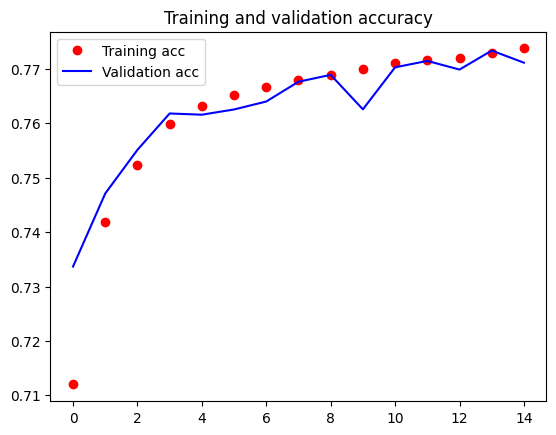

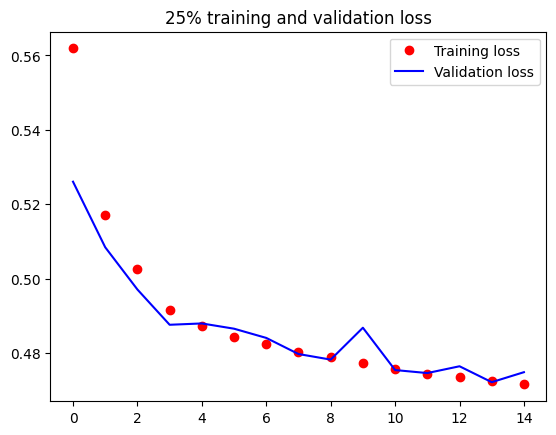

In [53]:
# create the plot
acc_50 = history_50['accuracy']
val_acc_50 = history_50['val_accuracy']
loss_50 = history_50['loss']
val_loss_50 = history_50['val_loss']

epochs = range(len(acc_50))

plt.plot(epochs, acc_50, 'ro', label='Training acc')
plt.plot(epochs, val_acc_50, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_50, 'ro', label='Training loss')
plt.plot(epochs, val_loss_50, 'b', label='Validation loss')
plt.title('25% training and validation loss')
plt.legend()

plt.show()

Comment:

When it comes to accuracy, validation started around 0.73. Both training and validation followed a similar trend, with a notable dip observed at the 9th epoch in the validation set. Despite this, both training and validation accuracies increased steadily, forming a curvy line with slight fluctuations and eventually reaching around 0.77.

Regarding loss, validation started around 0.52. Both training and validation exhibited a similar trend, with a significant protrusion seen at the 9th epoch in the validation set. However, both training and validation losses decreased steadily, forming a curvy line with slight fluctuations, and eventually reached below 0.48.

In [54]:
model_50.compile(metrics=fresh_metrics())
# Evaluate Model with 50% of the Training Data
model_50_results = model_50.evaluate(test_data, return_dict=True)
model_50_results

313/313 [==============================] - 8s 22ms/step - loss: 0.0000e+00 - tp: 129667.0000 - fp: 43030.0000 - tn: 116902.0000 - fn: 30401.0000 - accuracy: 0.7705 - precision: 0.7508 - recall: 0.8101


{'loss': 0.0,
 'tp': 129667.0,
 'fp': 43030.0,
 'tn': 116902.0,
 'fn': 30401.0,
 'accuracy': 0.7705281376838684,
 'precision': 0.7508352994918823,
 'recall': 0.8100744485855103}

## Compare and comment on the results



Analysing the classification metrics, as the percentage of the training dataset usage increased, the accuracy also increased. Specifically, the models trained with 10%, 25%, and 50% of the training dataset achieved accuracy percentages of 0.7533, 0.7621, and 0.7705, respectively.

However, when considering precision, the model trained with 25% of the training dataset showed the highest percentage at 0.7738. On the other hand, the recall metric reached its highest value of 0.8101 for the model trained with 50% of the training dataset. Consequently, the model trained with 50% of the dataset yielded the best performance overall.

#  Adjusting the number of LSTM modules

The second part your investigation is how the number of LSTM modules impacts the performance of the model.

For your models you should:
* create and use a 250-word encoder
* use 25% of the training data
* train for 15 epochs

Create two models, one with 8 LSTM units and the other with 12 LSTM units. 

## Training with 8 LSTM modules

In [19]:
# put your code here
# Build the model with 8 LSTM units
model_8_units = Sequential([
    encoder250,
    Embedding(input_dim=len(encoder250.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(8),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_8_units.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=fresh_metrics())

# Train the model
history_8_units = model_8_units.fit(
    train_data25, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

# Save the model and training history
model_8_units.save('model_8_units.keras')
with open('history_8_units.json', 'w') as f:
    json.dump(history_8_units.history, f)

Epoch 1/15
879/879 [==============================] - 59s 32ms/step - loss: 0.4957 - tp: 331814.0000 - fp: 95200.0000 - tn: 354438.0000 - fn: 118644.0000 - accuracy: 0.7624 - precision: 0.7771 - recall: 0.7366 - val_loss: 0.4450 - val_tp: 31514.0000 - val_fp: 8307.0000 - val_tn: 31761.0000 - val_fn: 8418.0000 - val_accuracy: 0.7909 - val_precision: 0.7914 - val_recall: 0.7892
Epoch 2/15
879/879 [==============================] - 26s 30ms/step - loss: 0.4258 - tp: 358161.0000 - fp: 86726.0000 - tn: 362912.0000 - fn: 92297.0000 - accuracy: 0.8011 - precision: 0.8051 - recall: 0.7951 - val_loss: 0.4119 - val_tp: 31832.0000 - val_fp: 7213.0000 - val_tn: 32855.0000 - val_fn: 8100.0000 - val_accuracy: 0.8086 - val_precision: 0.8153 - val_recall: 0.7972
Epoch 3/15
879/879 [==============================] - 26s 30ms/step - loss: 0.4058 - tp: 364097.0000 - fp: 82531.0000 - tn: 367107.0000 - fn: 86361.0000 - accuracy: 0.8124 - precision: 0.8152 - recall: 0.8083 - val_loss: 0.4012 - val_tp: 32706

In [20]:
# Reload
model_8_units = tf.keras.models.load_model('model_8_units.keras')
with open('history_8_units.json') as f:
    history_8_units = json.load(f)

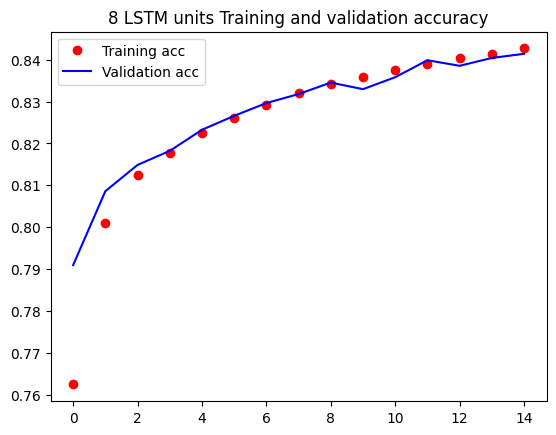

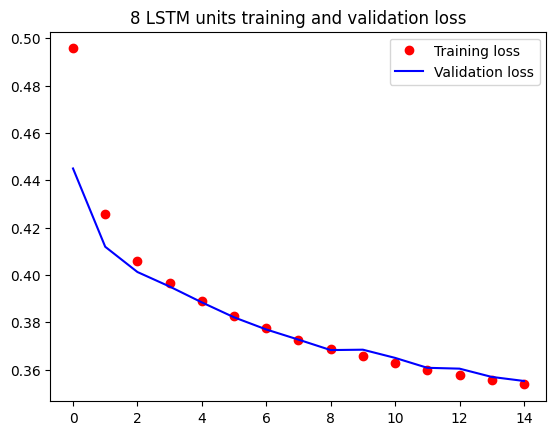

In [22]:
#create the plot
acc_8 = history_8_units['accuracy']
val_acc_8 = history_8_units['val_accuracy']
loss_8 = history_8_units['loss']
val_loss_8 = history_8_units['val_loss']

epochs = range(len(acc_8))

plt.plot(epochs, acc_8, 'ro', label='Training acc')
plt.plot(epochs, val_acc_8, 'b', label='Validation acc')
plt.title('8 LSTM units Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_8, 'ro', label='Training loss')
plt.plot(epochs, val_loss_8, 'b', label='Validation loss')
plt.title('8 LSTM units training and validation loss')
plt.legend()

plt.show()

Comment:

When considering accuracy, validation began at approximately 0.79. Both training and validation followed a similar trend, increasing gradually and forming a slightly curved line. It is observed that there were slight fluctuations in validation after the 8th epochs, with both training and validation eventually reaching around 0.84.

Regarding loss, validation commenced at around 0.44. Both training and validation exhibited a similar trend, gradually decreasing with a slight curvature, and eventually reaching below 0.36.

In [23]:
model_8_units.compile(metrics=fresh_metrics())
# Evaluate Model with 8 LSTM units
model_8_units_results = model_8_units.evaluate(test_data, return_dict=True)
model_8_units_results

313/313 [==============================] - 8s 23ms/step - loss: 0.0000e+00 - tp: 136797.0000 - fp: 27180.0000 - tn: 132752.0000 - fn: 23271.0000 - accuracy: 0.8423 - precision: 0.8342 - recall: 0.8546


{'loss': 0.0,
 'tp': 136797.0,
 'fp': 27180.0,
 'tn': 132752.0,
 'fn': 23271.0,
 'accuracy': 0.8423406481742859,
 'precision': 0.8342450261116028,
 'recall': 0.8546180129051208}

## Training with 12 LSTM modules

In [24]:
# put your code here
# Build the model with 12 LSTM units
model_12_units = Sequential([
    encoder250,
    Embedding(input_dim=len(encoder250.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(12),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_12_units.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=fresh_metrics())

# Train the model
history_12_units = model_12_units.fit(
    train_data25, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

# Save the model and training history
model_12_units.save('model_12_units.keras')
with open('history_12_units.json', 'w') as f:
    json.dump(history_12_units.history, f)

Epoch 1/15
879/879 [==============================] - 33s 31ms/step - loss: 0.4867 - tp: 340193.0000 - fp: 101789.0000 - tn: 347849.0000 - fn: 110265.0000 - accuracy: 0.7644 - precision: 0.7697 - recall: 0.7552 - val_loss: 0.4525 - val_tp: 30929.0000 - val_fp: 8253.0000 - val_tn: 31815.0000 - val_fn: 9003.0000 - val_accuracy: 0.7843 - val_precision: 0.7894 - val_recall: 0.7745
Epoch 2/15
879/879 [==============================] - 26s 30ms/step - loss: 0.4349 - tp: 352716.0000 - fp: 86921.0000 - tn: 362717.0000 - fn: 97742.0000 - accuracy: 0.7948 - precision: 0.8023 - recall: 0.7830 - val_loss: 0.4092 - val_tp: 31788.0000 - val_fp: 7150.0000 - val_tn: 32918.0000 - val_fn: 8144.0000 - val_accuracy: 0.8088 - val_precision: 0.8164 - val_recall: 0.7961
Epoch 3/15
879/879 [==============================] - 26s 30ms/step - loss: 0.4001 - tp: 362541.0000 - fp: 78659.0000 - tn: 370979.0000 - fn: 87917.0000 - accuracy: 0.8149 - precision: 0.8217 - recall: 0.8048 - val_loss: 0.3956 - val_tp: 3299

In [19]:
# Reload
model_12_units = tf.keras.models.load_model('model_12_units.keras')
with open('history_12_units.json') as f:
    history_12_units = json.load(f)

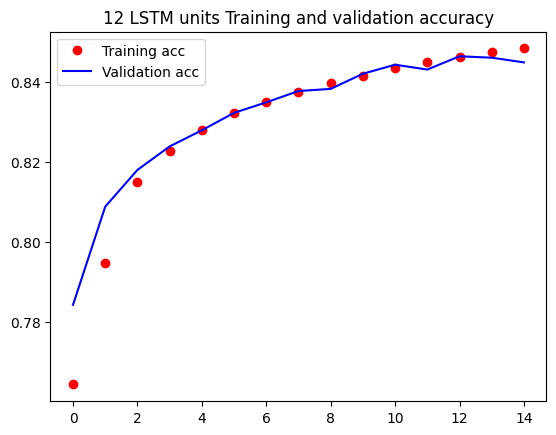

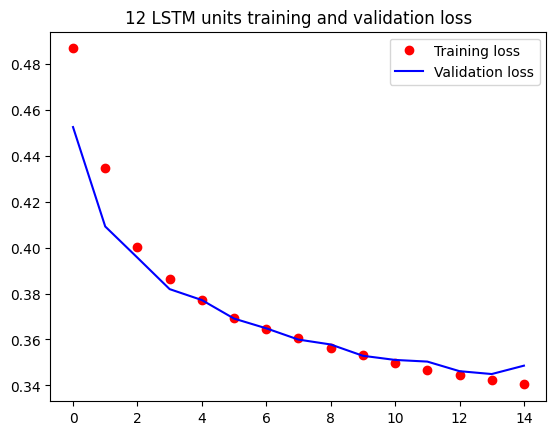

In [20]:
#creat the plot
acc_12 = history_12_units['accuracy']
val_acc_12 = history_12_units['val_accuracy']
loss_12 = history_12_units['loss']
val_loss_12 = history_12_units['val_loss']

epochs = range(len(acc_12))

plt.plot(epochs, acc_12, 'ro', label='Training acc')
plt.plot(epochs, val_acc_12, 'b', label='Validation acc')
plt.title('12 LSTM units Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_12, 'ro', label='Training loss')
plt.plot(epochs, val_loss_12, 'b', label='Validation loss')
plt.title('12 LSTM units training and validation loss')
plt.legend()

plt.show()

Comment:

When considering accuracy, validation began at above 0.78. Both training and validation followed a similar trend, increasing gradually and forming a slightly curved line. It was observed that there were slight fluctuations in validation after the 8th epoch, with both training and validation eventually reaching around 0.84. However, while the training accuracy kept increasing, the validation loss saw a slight decrease after the 12th epoch.

Regarding loss, validation commenced at around 0.45. Both training and validation exhibited a similar trend, gradually decreasing with a slight curvature, and eventually reaching below 0.36. However, while the training loss kept decreasing, the validation loss saw a slight increase in the end.

In [21]:
model_12_units.compile(metrics=fresh_metrics())
# Evaluate Model with 12 LSTM units
model_12_units_results = model_12_units.evaluate(test_data, return_dict=True)
model_12_units_results

313/313 [==============================] - 9s 24ms/step - loss: 0.0000e+00 - tp: 129593.0000 - fp: 19000.0000 - tn: 140932.0000 - fn: 30475.0000 - accuracy: 0.8454 - precision: 0.8721 - recall: 0.8096


{'loss': 0.0,
 'tp': 129593.0,
 'fp': 19000.0,
 'tn': 140932.0,
 'fn': 30475.0,
 'accuracy': 0.8453906178474426,
 'precision': 0.8721339702606201,
 'recall': 0.8096121549606323}

##  Compare and comment on the results



Regarding accuracy and precision, training with 12 LSTM modules showed slightly better results compared to training with 8 LSTM modules. The accuracy and precision values were 0.8454 and 0.8721, respectively, with 12 LSTM, while they were 0.8423 and 0.8342 with 8 LSTM modules.

However, in terms of recall, 8 LSTM modules achieved a better score than 12 LSTM modules (8 LSTM: 0.8546, 12 LSTM: 0.8096). In conclusion, from the perspective of accuracy, increasing the number of LSTM modules tends to improve performance.

# Adjusting the size of the vocabulary

The third investigation is how size of the encoder's vocabulary impacts the performance of the model.

For your models you should:
* use a model with 4 LSTM modules
* use 25% of the training data
* train for 15 epochs

Create two models, one using an encoder with a 250-word vocabulary and the other with a 500-word vocabulary. 

## Q1(c)i Training with 250 vocab length

In [22]:
# put your code here

# Build the model with a 250-word vocabulary encoder
model_250_vocab = Sequential([
    encoder250,
    Embedding(input_dim=len(encoder250.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_250_vocab.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=fresh_metrics())

# Train the model
history_250_vocab = model_250_vocab.fit(
    train_data25, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

# Save the model and training history
model_250_vocab.save('model_250_vocab.keras')
with open('history_250_vocab.json', 'w') as f:
    json.dump(history_250_vocab.history, f)


Epoch 1/15
879/879 [==============================] - 59s 32ms/step - loss: 0.4995 - tp: 333922.0000 - fp: 100491.0000 - tn: 349607.0000 - fn: 116076.0000 - accuracy: 0.7594 - precision: 0.7687 - recall: 0.7421 - val_loss: 0.4534 - val_tp: 30074.0000 - val_fp: 7338.0000 - val_tn: 32730.0000 - val_fn: 9858.0000 - val_accuracy: 0.7850 - val_precision: 0.8039 - val_recall: 0.7531
Epoch 2/15
879/879 [==============================] - 27s 31ms/step - loss: 0.4383 - tp: 351091.0000 - fp: 86219.0000 - tn: 363879.0000 - fn: 98907.0000 - accuracy: 0.7943 - precision: 0.8028 - recall: 0.7802 - val_loss: 0.4276 - val_tp: 29584.0000 - val_fp: 5546.0000 - val_tn: 34522.0000 - val_fn: 10348.0000 - val_accuracy: 0.8013 - val_precision: 0.8421 - val_recall: 0.7409
Epoch 3/15
879/879 [==============================] - 27s 31ms/step - loss: 0.4158 - tp: 359478.0000 - fp: 82201.0000 - tn: 367897.0000 - fn: 90520.0000 - accuracy: 0.8081 - precision: 0.8139 - recall: 0.7988 - val_loss: 0.4112 - val_tp: 333

In [23]:
# Reload
model_250_vocab = tf.keras.models.load_model('model_250_vocab.keras')
with open('history_250_vocab.json') as f:
    history_250_vocab = json.load(f)

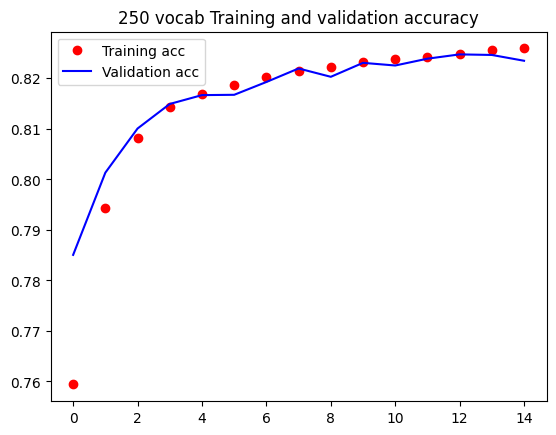

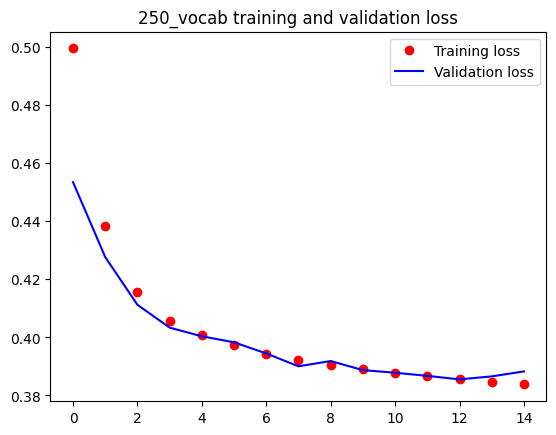

In [24]:
# Create plots
acc_250_vocab = history_250_vocab['accuracy']
val_acc_250_vocab = history_250_vocab['val_accuracy']
loss_250_vocab = history_250_vocab['loss']
val_loss_250_vocab = history_250_vocab['val_loss']

epochs = range(len(acc_250_vocab))

plt.plot(epochs, acc_250_vocab, 'ro', label='Training acc')
plt.plot(epochs, val_acc_250_vocab, 'b', label='Validation acc')
plt.title('250 vocab Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_250_vocab, 'ro', label='Training loss')
plt.plot(epochs, val_loss_250_vocab, 'b', label='Validation loss')
plt.title('250_vocab training and validation loss')
plt.legend()

plt.show()

Comment:

When considering accuracy, validation began above 0.78. Both training and validation followed a similar trend, increasing dramatically up to the 4th epoch before gradually increasing towards the end. Both training and validation eventually reached around 0.82. However, while the training accuracy kept increasing, the validation loss saw a slight decrease after the 13th epoch.

Regarding loss, validation commenced below 0.46. Both training and validation exhibited a similar trend, dramatically decreasing up to the 3rd epoch before gradually decreasing towards the end. Eventually, they reached around 0.38. However, while the training loss kept decreasing, the validation loss saw a slight increase in the end.

In [25]:
model_250_vocab.compile(metrics=fresh_metrics())
# Evaluate Model with 250 vocab
model_250_vocab_results = model_250_vocab.evaluate(test_data, return_dict=True)
model_250_vocab_results

313/313 [==============================] - 8s 21ms/step - loss: 0.0000e+00 - tp: 136861.0000 - fp: 33217.0000 - tn: 126715.0000 - fn: 23207.0000 - accuracy: 0.8237 - precision: 0.8047 - recall: 0.8550


{'loss': 0.0,
 'tp': 136861.0,
 'fp': 33217.0,
 'tn': 126715.0,
 'fn': 23207.0,
 'accuracy': 0.8236749768257141,
 'precision': 0.8046954870223999,
 'recall': 0.8550178408622742}

## Training with 500 vocab length

In [26]:
# put your code here
# Build the model with a 500-word vocabulary encoder
model_500_vocab = Sequential([
    encoder500,
    Embedding(input_dim=len(encoder500.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_500_vocab.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=fresh_metrics())

# Train the model
history_500_vocab = model_500_vocab.fit(
    train_data25, 
    validation_data=validation_data, 
    epochs=15, 
    verbose=1)

# Save the model and training history
model_500_vocab.save('model_500_vocab.keras')
with open('history_500_vocab.json', 'w') as f:
    json.dump(history_500_vocab.history, f)

Epoch 1/15
879/879 [==============================] - 35s 34ms/step - loss: 0.4608 - tp: 359352.0000 - fp: 93640.0000 - tn: 356458.0000 - fn: 90646.0000 - accuracy: 0.7953 - precision: 0.7933 - recall: 0.7986 - val_loss: 0.3968 - val_tp: 32725.0000 - val_fp: 6920.0000 - val_tn: 33148.0000 - val_fn: 7207.0000 - val_accuracy: 0.8234 - val_precision: 0.8255 - val_recall: 0.8195
Epoch 2/15
879/879 [==============================] - 28s 32ms/step - loss: 0.3806 - tp: 375580.0000 - fp: 77698.0000 - tn: 372400.0000 - fn: 74418.0000 - accuracy: 0.8310 - precision: 0.8286 - recall: 0.8346 - val_loss: 0.3668 - val_tp: 34502.0000 - val_fp: 7519.0000 - val_tn: 32549.0000 - val_fn: 5430.0000 - val_accuracy: 0.8381 - val_precision: 0.8211 - val_recall: 0.8640
Epoch 3/15
879/879 [==============================] - 28s 31ms/step - loss: 0.3565 - tp: 380542.0000 - fp: 70966.0000 - tn: 379132.0000 - fn: 69456.0000 - accuracy: 0.8440 - precision: 0.8428 - recall: 0.8457 - val_loss: 0.3512 - val_tp: 35389.

In [27]:
# Reload
model_500_vocab = tf.keras.models.load_model('model_500_vocab.keras')
with open('history_500_vocab.json') as f:
    history_500_vocab = json.load(f)

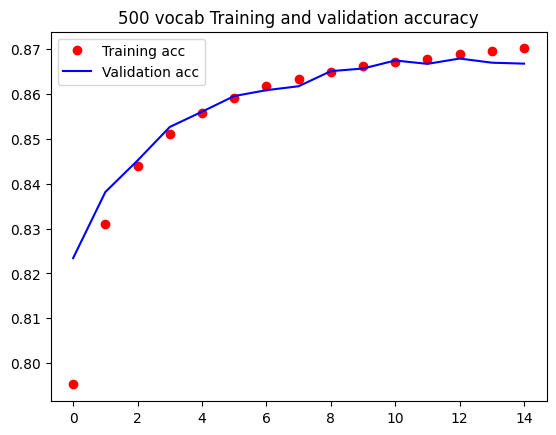

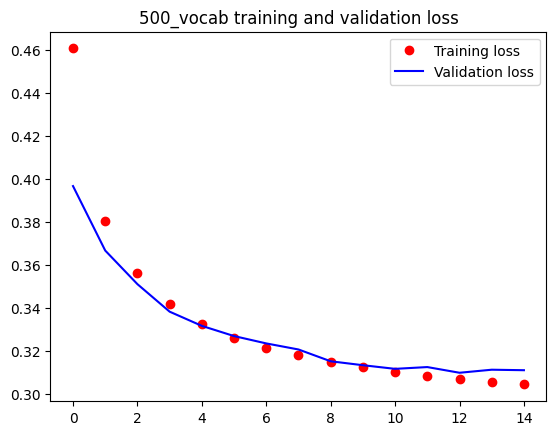

In [28]:
# Create the plot
acc_500_vocab = history_500_vocab['accuracy']
val_acc_500_vocab = history_500_vocab['val_accuracy']
loss_500_vocab = history_500_vocab['loss']
val_loss_500_vocab = history_500_vocab['val_loss']

epochs = range(len(acc_500_vocab))

plt.plot(epochs, acc_500_vocab, 'ro', label='Training acc')
plt.plot(epochs, val_acc_500_vocab, 'b', label='Validation acc')
plt.title('500 vocab Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_500_vocab, 'ro', label='Training loss')
plt.plot(epochs, val_loss_500_vocab, 'b', label='Validation loss')
plt.title('500_vocab training and validation loss')
plt.legend()

plt.show()

Comment:

When considering accuracy, validation began above 0.82. Both training and validation followed a similar trend, increasing gradually and drawing a curve line. Both training and validation eventually reached around 0.87. However, while the training accuracy kept increasing, the validation loss saw a slight decrease after the 12th epoch.

Regarding loss, validation commenced below 0.40. Both training and validation exhibited a similar trend, gradually  decreasing and drawing a curve. Eventually, they reached around 0.31. However, while the training loss kept decreasing, the validation loss saw a slight stayble trend in the end.

In [29]:
model_500_vocab.compile(metrics=fresh_metrics())
# Evaluate Model with 500 vocab
model_500_vocab_results = model_500_vocab.evaluate(test_data, return_dict=True)
model_500_vocab_results

313/313 [==============================] - 8s 22ms/step - loss: 0.0000e+00 - tp: 143699.0000 - fp: 26633.0000 - tn: 133299.0000 - fn: 16369.0000 - accuracy: 0.8656 - precision: 0.8436 - recall: 0.8977


{'loss': 0.0,
 'tp': 143699.0,
 'fp': 26633.0,
 'tn': 133299.0,
 'fn': 16369.0,
 'accuracy': 0.8656187653541565,
 'precision': 0.8436406254768372,
 'recall': 0.8977372050285339}

## Compare and comment on the results

Comparing accuracy, precision, and recall, training with a vocabulary length of 500 performed better than training with a vocabulary length of 250. While the accuracy, precision, and recall with a vocabulary length of 250 were 0.8237, 0.8047, and 0.8550, respectively, those with a vocabulary length of 500 were 0.8237, 0.8047, and 0.8550, respectively. Therefore, increasing the vocabulary length resulted in better performance.

# The best model consideration

## What would make the best model?

The experiments so far suggest that increasing the volume of the dataset, the number of LSTM modules, and the length of the vocabulary for an encoder lead to better performance. Therefore, it is expected that the best model is the one using 12 LSTM modules and an encoder with a 500-word vocabulary trained on the full dataset.

## Create and train the model

In [ ]:
# Put your solution here


# Build the model with a 500-word vocabulary encoder and 12 LSTM modules
model_500_vocab_12_lstm = Sequential([
    encoder500,
    Embedding(input_dim=len(encoder500.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(12),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_500_vocab_12_lstm.compile(loss='binary_crossentropy',
                                optimizer='adam',
                                metrics=fresh_metrics())

# Train the model
history_500_vocab_12_lstm = model_500_vocab_12_lstm.fit(
    train_data,  # Using all training data
    validation_data=validation_data, 
    epochs=15, 
    verbose=0)

# Save the model and training history
model_500_vocab_12_lstm.save('model_500_vocab_12_lstm.keras')
with open('history_500_vocab_12_lstm.json', 'w') as f:
    json.dump(history_500_vocab_12_lstm.history, f)

In [31]:
# Reload
model_500_vocab_12_lstm = tf.keras.models.load_model('model_500_vocab_12_lstm.keras')
with open('history_500_vocab_12_lstm.json') as f:
    history_500_vocab_12_lstm = json.load(f)

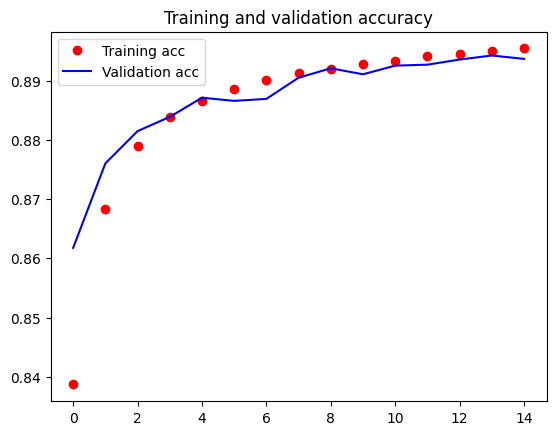

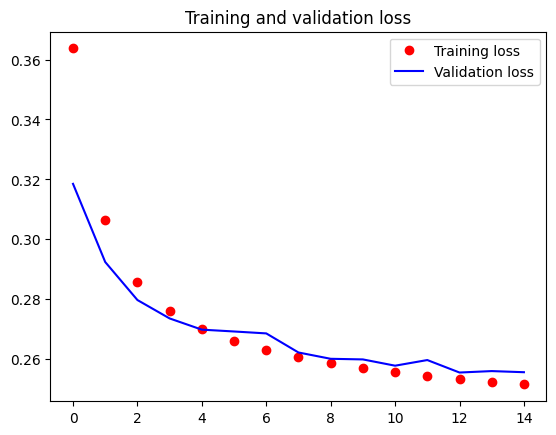

In [32]:
# crete plots
acc_q1d = history_500_vocab_12_lstm['accuracy']
val_acc_q1d = history_500_vocab_12_lstm['val_accuracy']
loss_q1d = history_500_vocab_12_lstm['loss']
val_loss_q1d = history_500_vocab_12_lstm['val_loss']

epochs = range(len(acc_q1d))

plt.plot(epochs, acc_q1d, 'ro', label='Training acc')
plt.plot(epochs, val_acc_q1d, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_q1d, 'ro', label='Training loss')
plt.plot(epochs, val_loss_q1d, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Comment:

When it comes to accuracy, validation started around 0.86. Both training and validation followed a similar trend, with a slight dip observed at the 6th epoch in the validation set. Despite this, both training and validation accuracies increased steadily, forming a curvy line  and eventually reaching around 0.89.

Regarding loss, validation started around 0.32. Both training and validation exhibited a similar trend, with a slight protrusion seen at the 6th epoch and 11th epoch in the validation set. However, both training and validation losses decreased steadily, forming a curvy line with slight fluctuations, and eventually reached below 0.26.

In [33]:
model_500_vocab_12_lstm.compile(metrics=fresh_metrics())
# Evaluate Model
model_500_vocab_12_lstm_results = model_500_vocab_12_lstm.evaluate(test_data, return_dict=True)
model_500_vocab_12_lstm_results

313/313 [==============================] - 8s 22ms/step - loss: 0.0000e+00 - tp: 140625.0000 - fp: 14647.0000 - tn: 145285.0000 - fn: 19443.0000 - accuracy: 0.8935 - precision: 0.9057 - recall: 0.8785


{'loss': 0.0,
 'tp': 140625.0,
 'fp': 14647.0,
 'tn': 145285.0,
 'fn': 19443.0,
 'accuracy': 0.8934687376022339,
 'precision': 0.9056687355041504,
 'recall': 0.878532886505127}

## Comparison

 As anticipated, the model exhibited the best performance in terms of accuracy and precision, achieving scores of 0.8935 and 0.9057, respectively. However, the recall of 0.8785 from part (d) is lower than that of the model using an encoder with a 500-word vocabulary, 4 LSTM modules, and 25% of the training dataset, which achieved a recall of 0.8977.

Despite the slightly lower recall, as the last model attained the highest accuracy score, it is concluded that this is the best-performing model.